## Dynamic PAC-Bayes algorithms

This code is dedicated to test procedures described in (Haddouche & Guedj 2022). We use first the Boston Housing dataset and we aim to establish the best linear predictor for this problem. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import *
import scipy.stats as stat
import time
import random
from sklearn.datasets import load_boston

### Create dataset

In [2]:
# Import Boston Housing dataset from Sklearn
boston = load_boston()
bos = pd.DataFrame(boston.data)
bos['Target'] = boston.target
bos = bos.sample(len(bos))

# Create target array
Y = np.array(bos['Target'])
Y = (Y-Y.mean())/Y.std()
Y = np.concatenate((Y,Y),axis=0)

# Create (standardized) features array
bos_X = bos.drop('Target',1)
bos_X = (bos_X-bos_X.mean())/bos_X.std()
X = np.concatenate((np.array([[1]]*len(np.array(bos_X))),np.array(bos_X)),axis=1)
X= np.concatenate((X,X),axis=0)

# Dimensions of the problem
n = len(X)
d = len(X[0])

### Loss functions

In [3]:
def lr(theta,x,y):
    # input : feature x, label y, parameter theta
    # output : loss and gradient at theta
    v = np.dot(theta,x)
    loss = (y-v)**2/2 # = theta^T xx^T theta / 2 - y*theta^T x + y**2/2
    grad = np.dot(theta,x)*x - y*x
    return (loss,grad)

In [4]:
def g(m,sigma,x,y):
    # input : feature x, label y, parameter (m,sigma)
    # output : loss and gradient at (m,sigma)
    loss = ( np.dot(sigma**2,x**2) + np.dot(m,x)**2 ) /2 - y*np.dot(m,x) + y**2/2
    grad_m = np.dot(m,x)*x - y*x
    grad_sigma = sigma*x**2
    return (loss,grad_m,grad_sigma)

### Online Gradient Descent

In [5]:
def OGD(x,y,theta_0,eta):
    # input : dataset (x,y), intialization (theta_0), stepsize eta
    # output : sequence of means for each time step & cumulative loss
    theta_t = theta_0
    theta=[]
    cum_loss = 0
    CL = []
    hindsight_loss = 0
    hindsight = []
    for i in np.arange(len(x)):
        loss,grad = lr(theta_t,x[i],y[i])
        theta_t = theta_t - eta*grad
        theta_t = np.clip(theta_t,-20,20)
        theta.append(theta_t)
        cum_loss += loss
        CL.append(cum_loss/(i+1))
    return (np.array(theta),np.array(CL))

In [6]:
start=time.time()
theta_OGD,CL_OGD = OGD(X,Y,np.array([0]*d),1/np.sqrt(n))
end=time.time()
print('Running time :', end - start, 'seconds')

Running time : 0.019999980926513672 seconds


### Streaming Variational Bayes (SVB)

(extracted from Cherief-Abdellatif et al. 2019)

In [7]:
def SVB(x,y,eta,s):
    # input : dataset (x,y), intialization (theta_0), stepsize eta
    # output : sequence of means for each time step & cumulative loss
    m_t = np.array([0]*d)
    sigma_t = np.array([s]*d)
    m = []
    cum_loss = 0
    CL = []
    hindsight_loss = 0
    hindsight = []
    for i in np.arange(len(x)):
        _,grad_m,grad_sigma = g(m_t,sigma_t,x[i],y[i])
        loss,_ = lr(m_t,x[i],y[i])
        eta_t = eta/np.sqrt(i+1)/sigma_t**2
        m_t = m_t - eta_t*grad_m*sigma_t**2
        m_t = np.clip(m_t,-20,20)
        m.append(m_t)
        g_t = eta_t*sigma_t*grad_sigma/2
        sigma_t = (np.sqrt(1+g_t**2)-g_t)*sigma_t
        #loss,_ = lr(m_t,x[i],y[i])
        cum_loss += loss
        CL.append(cum_loss/(i+1))
    print(sigma_t)
    return (np.array(m),np.array(CL))

In [8]:
start=time.time()
theta_SVB,CL_SVB = SVB(X,Y,0.1,1)
end=time.time()
print('Running time :', end - start, 'seconds')

[0.04464961 0.06790198 0.0521873  0.05048761 0.03672243 0.055604
 0.04163879 0.04364481 0.05201422 0.04629085 0.04509966 0.05534694
 0.04580149 0.04223039]
Running time : 0.03975701332092285 seconds


### Online PAC-Bayesian algorithm with Gaussian Prior and Gibbs posteriors

with the choice $Q_1= \mathcal{N}(0,\mathbf{I}_d)$

In [20]:
it_MC= 500
def OPB_Gibbs(x,y,llambda):
    l = lambda theta,yy,xx : (yy- np.dot(theta,xx))**2/2
    m=[[0]*d]
    cum_loss = 0
    CL = []
    for i in np.arange(len(x)):
        f = lambda theta : np.exp(-llambda*np.sum([l(theta,y[j],x[j]) for j in range (len(x[:i]))]))
        #estimation of the mean of the exponentiated cumulative loss function
        temp_mean=0
        for j in range(it_MC):
            theta= stat.norm(scale=1.5).rvs(size= d)
            temp_mean+= (1/it_MC)*f(theta)
        #estimation of the true mean i.e.
        m_t = [0]*d
        for j in range(it_MC):
            theta_f= stat.norm(scale=1.5).rvs(size= d)
            h= (f(theta_f)/temp_mean)*theta_f
            m_t += h
        m_t2=[0]*d
        m_t2= m_t/it_MC
        m.append(m_t2)
        loss,_ = lr(m_t2,x[i],y[i])
        cum_loss += loss
        CL.append(cum_loss/(i+1))
    return(np.array(m),np.array(CL))

In [21]:
start=time.time()
theta_OPB_Gibbs,CL_OPB_Gibbs = OPB_Gibbs(X,Y,1/n)
end=time.time()
print('Running time :', end - start, 'seconds')

Running time : 1179.4001400470734 seconds


### Online PAC-Bayesian algorithm with Laplace prior and Gibbs posterior

In [11]:
it_MC= 500
def OPB_Gibbs_Laplace(x,y,llambda):
    l = lambda theta,yy,xx : (yy- np.dot(theta,xx))**2/2
    m=[[0]*d]
    cum_loss = 0
    CL = []
    for i in np.arange(len(x)):
        f = lambda theta : np.exp(-llambda*np.sum([l(theta,y[j],x[j]) for j in range (len(x[:i]))]))
        #estimation of the mean of the exponentiated cumulative loss function
        temp_mean=0
        for j in range(it_MC):
            theta= stat.laplace.rvs(size= d)
            temp_mean+= (1/it_MC)*f(theta)
        #estimation of the true mean i.e.
        m_t = [0]*d
        for j in range(it_MC):
            theta_f= stat.laplace.rvs(size= d)
            h= (f(theta_f)/(0.000001+temp_mean))*theta_f
            m_t += h
        m_t2=[0]*d
        m_t2= m_t/it_MC
        m.append(m_t2)
        loss,_ = lr(m_t2,x[i],y[i])
        cum_loss += loss
        CL.append(cum_loss/(i+1))
    return(np.array(m),np.array(CL))

In [12]:
start=time.time()
theta_OPB_Gibbs_Laplace,CL_OPB_Gibbs_Laplace = OPB_Gibbs_Laplace(X,Y,1/n)
end=time.time()
print('Running time :', end - start, 'seconds')

Running time : 812.1281931400299 seconds


### Comparison between SVB and OPB alg with Gibs posteriors

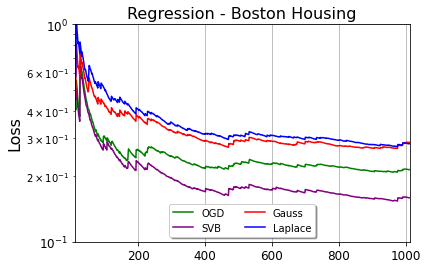

In [22]:
plt.figure()
plt.plot(CL_OGD,color= 'green', label= 'OGD')
plt.plot(CL_SVB,color='purple',label='SVB')
plt.plot(CL_OPB_Gibbs,color='red',label='Gauss')
plt.plot(CL_OPB_Gibbs_Laplace,color='blue',label='Laplace')
plt.legend(loc=8, ncol=2, shadow=True)
plt.xlim((10,n))
plt.ylim((0.1,1))
plt.yscale('log')
plt.grid()
plt.title('Regression - Boston Housing',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### OPBD algorithm 
(with $\Psi$ from Rivasplata et al. 2020) 

In [14]:
def OPBD_Riva(x,y,llambda,sigma):
    # input : dataset (x,y), intialization (theta_0), stepsize llambda
    # output : sequence of means for each time step & cumulative loss
    m_t = np.array([0]*d)
    h_t= np.array([0]*d)
    eps_t= stat.norm(scale=sigma).rvs(size= d)
    m = []
    cum_loss = 0
    CL = []
    for i in np.arange(len(x)):
        # Draw of a new predictor and evaluation of its efficiency
        h_t= m_t + stat.norm(scale=sigma).rvs(size= d)
        loss,_ = lr(h_t,x[i],y[i])
        # Construction of the next predictor
        eps_t= stat.norm(scale=sigma).rvs(size= d)
        _,grad = lr(m_t+eps_t,x[i],y[i])
        grad= grad/(sigma**2)
        m_t = m_t - eps_t - llambda*grad
        m_t = np.clip(m_t,-20,20)
        m.append(m_t)
        cum_loss += loss 
        CL.append(cum_loss/(i+1))
    return (np.array(m),np.array(CL))

In [15]:
start=time.time()
#theta_OPBD_Riva,CL_OPBD_Riva = OPBD_Riva(X,Y,0.0001/np.sqrt(n),0.01) 
theta_OPBD_Riva,CL_OPBD_Riva = OPBD_Riva(X,Y,0.0001/n,0.003)
end=time.time()
print('Running time :', end - start, 'seconds')

Running time : 0.8156521320343018 seconds


In [16]:
theta_OPBD_Riva[n-1]

array([-4.20260001e-03, -1.64516078e-01,  7.14342287e-02, -7.51196605e-02,
        1.38996770e-01, -1.06981105e-01,  2.82925688e-01, -2.80082414e-04,
       -2.79727750e-01,  2.48783422e-01, -5.90037523e-02, -1.97056679e-01,
        1.23180259e-01, -4.72110907e-01])

### OPBD algorithm
(with $\Psi$ from Viallard et al. 2021)

In [17]:
def OPBD_Via(x,y,llambda,sigma):
    # input : dataset (x,y), intialization (theta_0), stepsize llambda
    # output : sequence of means for each time step & cumulative loss
    m_t = np.array([0]*d)
    h_t= np.array([0]*d)
    eps_t= stat.norm(scale=sigma).rvs(size= d)
    m = []
    cum_loss = 0
    CL = []
    for i in np.arange(len(x)):
        # Draw of a new predictor and evaluation of its efficiency
        h_t= m_t + stat.norm(scale=sigma).rvs(size= d)
        loss,_ = lr(h_t,x[i],y[i])
        # Construction of the next predictor
        eps_t= stat.norm(scale=sigma).rvs(size= d)
        _,grad = lr(m_t+eps_t,x[i],y[i])
        grad= grad/(sigma**2)
        m_t = m_t - llambda*grad
        m_t = np.clip(m_t,-20,20)
        m.append(m_t)
        cum_loss += loss
        CL.append(cum_loss/(i+1))
    return (np.array(m),np.array(CL))

In [18]:
start=time.time()
#theta_OPBD_Via,CL_OPBD_Via = OPBD_Via(X,Y,0.0001/np.sqrt(n),0.02)
theta_OPBD_Via,CL_OPBD_Via = OPBD_Via(X,Y,0.002/n,0.01)
end=time.time()
print('Running time :', end - start, 'seconds')

Running time : 0.812593936920166 seconds


### Comparison with classical methods

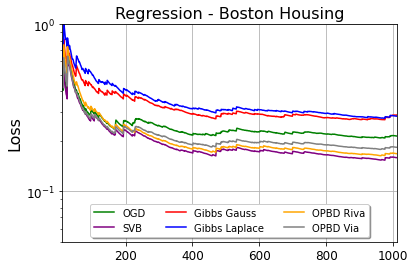

In [25]:
plt.figure()
plt.plot(CL_OGD,color= 'green', label= 'OGD')
plt.plot(CL_SVB,color='purple',label='SVB')
plt.plot(CL_OPB_Gibbs,color='red',label='Gibbs Gauss')
plt.plot(CL_OPB_Gibbs_Laplace,color='blue',label='Gibbs Laplace')
plt.plot(CL_OPBD_Riva,color='orange',label='OPBD Riva')
plt.plot(CL_OPBD_Via,color='grey',label='OPBD Via')
plt.legend(loc=8, ncol=3, shadow=True)
plt.xlim((10,n))
plt.ylim((0.05,1))
plt.yscale('log')
plt.grid()
plt.title('Regression - Boston Housing',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('reg_boston.pdf')
plt.show()